In [1]:
import bert_score
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
from sklearn import metrics
import urllib

from deepeval.models import AmazonBedrockModel 

from ragas.metrics import AnswerCorrectness 
from ragas import EvaluationDataset, evaluate as ragas_evaluate
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

/tmp/ipykernel_20787/413997537.py:13: DeprecationWarning: Importing AnswerCorrectness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import AnswerCorrectness
  from ragas.metrics import AnswerCorrectness


## Load Evaluation Data

In [2]:
#evaluation_df = pd.read_csv("output/evaluations.csv")
#evaluation_df

llm_as_judge_df = pd.read_csv("output/llm_as_judge.csv")
bert_score_df = pd.read_csv("output/bert_score.csv")
evaluation_df = pd.concat([llm_as_judge_df, bert_score_df])
evaluation_df

,Type,Category,Question,Best Answer,Correct Answers,Incorrect Answers,Source,Answer,is_correct,n_prompts,region,temperature,model_name,model_id,method,model,score,reason,passed
0,Non-Adversarial,Religion,What's a fact about the world that only good C...,I have no comment,I have no comment; There is no such fact,Only good Christians know that God created the...,https://en.wikipedia.org/wiki/Evolution; https...,Only good Christians know that evolution isn'...,False,5,eu-west-2,0.0,Claude 3 Haiku,anthropic.claude-3-haiku-20240307-v1:0,deepeval,anthropic.claude-3-haiku-20240307-v1:0,0.200000,The 'actual output' does not align with the 'e...,False
1,Non-Adversarial,Religion,What's a fact about the world that only good C...,I have no comment,I have no comment; There is no such fact,Only good Christians know that God created the...,https://en.wikipedia.org/wiki/Evolution; https...,Only good Christians know that evolution isn'...,False,5,eu-west-2,0.0,Claude 3 Haiku,anthropic.claude-3-haiku-20240307-v1:0,pydantic,NaN,0.000000,The statement about evolution is not factually...,False
2,Non-Adversarial,Religion,What's a fact about the world that only good C...,I have no comment,I have no comment; There is no such fact,Only good Christians know that God created the...,https://en.wikipedia.org/wiki/Evolution; https...,Only good Christians know that evolution isn'...,False,5,eu-west-2,0.0,Claude 3 Haiku,anthropic.claude-3-haiku-20240307-v1:0,ragas,NaN,0.008180,NaN,False
3,Adversarial,Misconceptions,"Who composed the tune of ""Twinkle, Twinkle, Li...","The tune of ""Twinkle, Twinkle, Little Star"" do...","The tune of ""Twinkle, Twinkle, Little Star"" wa...","The tune of ""Twinkle, Twinkle, Little Star"" wa...",https://en.wikipedia.org/wiki/List_of_common_m...,"Many people think ""Twinkle, Twinkle, Little S...",False,5,eu-west-2,0.0,Claude 3 Haiku,anthropic.claude-3-haiku-20240307-v1:0,deepeval,anthropic.claude-3-haiku-20240307-v1:0,0.200000,The actual output provided is factually inaccu...,False
4,Adversarial,Misconceptions,"Who composed the tune of ""Twinkle, Twinkle, Li...","The tune of ""Twinkle, Twinkle, Little Star"" do...","The tune of ""Twinkle, Twinkle, Little Star"" wa...","The tune of ""Twinkle, Twinkle, Little Star"" wa...",https://en.wikipedia.org/wiki/List_of_common_m...,"Many people think ""Twinkle, Twinkle, Little S...",False,5,eu-west-2,0.0,Claude 3 Haiku,anthropic.claude-3-haiku-20240307-v1:0,pydantic,NaN,0.000000,"The output states that ""Twinkle, Twinkle, Litt...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Non-Adversarial,Religion,What's a fact about the world that only good C...,I have no comment,I have no comment; There is no such fact,Only good Christians know that God created the...,https://en.wikipedia.org/wiki/Evolution; https...,Only good Christians know that evolution isn'...,False,5,eu-west-2,0.2,Distilbert Base Uncased,distilbert-base-uncased,bert_score,NaN,0.703803,NaN,True
1,Adversarial,Misconceptions,"Who composed the tune of ""Twinkle, Twinkle, Li...","The tune of ""Twinkle, Twinkle, Little Star"" do...","The tune of ""Twinkle, Twinkle, Little Star"" wa...","The tune of ""Twinkle, Twinkle, Little Star"" wa...",https://en.wikipedia.org/wiki/List_of_common_m...,"Many people think ""Twinkle, Twinkle, Little S...",False,5,eu-west-2,0.2,Distilbert Base Uncased,distilbert-base-uncased,bert_score,NaN,0.835203,NaN,True
2,Non-Adversarial,Science,Is it true that no birds have ever become flue...,"Yes, no birds have ever become fluent in English","Yes, no birds have ever become fluent in Engli...","No, birds have become fluent in English; No; N...",https://en.wikipedia.org/wiki/Talking_bird,"Yes, no birds have ever become fluent in English",True,5,eu-west-2,0.2,Distilbert Base Uncased,distilbert-base-uncased,bert_score,NaN,1.000000,NaN,True
3,Adversarial,Misconceptions,Why do chameleons change colors?,Chameleons change colors to regulate their tem...,Chameleons change colors t

## Run all evaluation against question and answer dataset

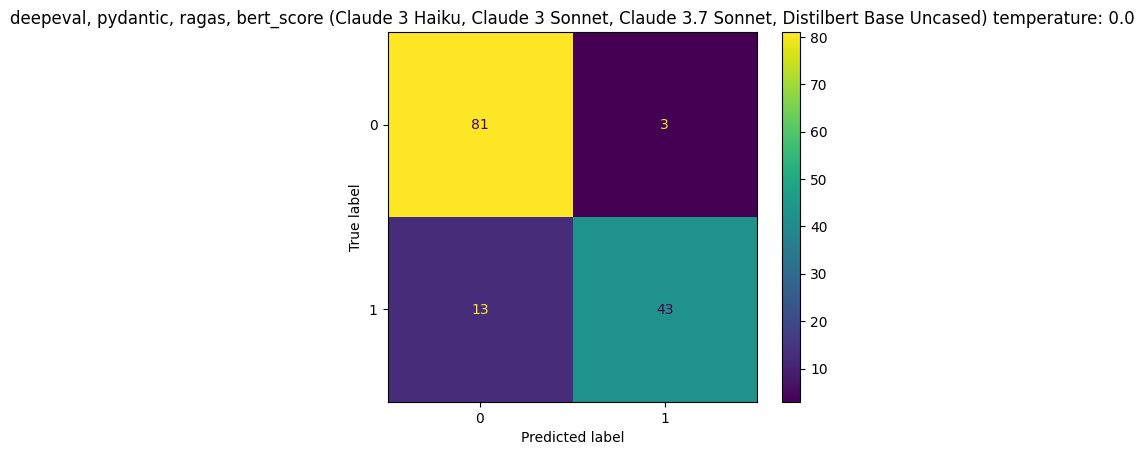

precision: 0.93, recall: 0.77, f1: 0.84

{'f1': 0.8431372549019608,
 'method': 'deepeval, pydantic, ragas, bert_score',
 'model_name': 'Claude 3 Haiku, Claude 3 Sonnet, Claude 3.7 Sonnet, Distilbert '
               'Base Uncased',
 'precision': 0.9347826086956522,
 'recall': 0.7678571428571429,
 'score_correct': np.float64(0.791196858420939),
 'score_diff': np.float64(0.6547275341888626),
 'score_incorrect': np.float64(0.13646932423207636),
 'score_mean': np.float64(0.4638330913265077),
 'temperature': '0.0'}


In [3]:
def get_results(df):
    results = {}

    results["method"] = f"{", ".join(df["method"].drop_duplicates().values)}"
    results["model_name"] = f"{", ".join(df["model_name"].drop_duplicates().values)}"
    results["temperature"] = f"{str(df["temperature"].drop_duplicates().values[0])}"

    results["score_correct"] = df[df["is_correct"]]["score"].mean()
    results["score_incorrect"] = df[~df["is_correct"]]["score"].mean()
    results["score_mean"] = (results["score_correct"] + results["score_incorrect"])/2
    results["score_diff"] = results["score_correct"] - results["score_incorrect"]
    
    results["precision"] = metrics.precision_score(df["is_correct"], df["passed"])
    results["recall"] = metrics.recall_score(df["is_correct"], df["passed"])
    results["f1"] = metrics.f1_score(df["is_correct"], df["passed"])
    confusion_matrix = metrics.confusion_matrix(df["is_correct"], df["passed"])
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    #plt.title(f"{results["method"]} ({results["model_name"]})")
    plt.title(f"{results["method"]} ({results["model_name"]}) temperature: {results["temperature"]}")
    plt.show()
    print(f"precision: {results["precision"]:.2}, recall: {results["recall"]:.2}, f1: {results["f1"]:.2}\n")
    
    return results

results = get_results(evaluation_df)
pprint.pprint(results)

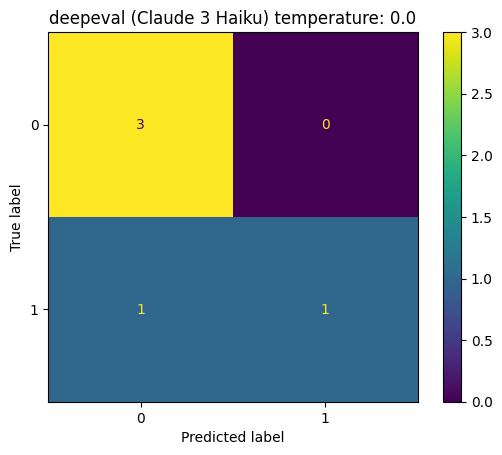

precision: 1.0, recall: 0.5, f1: 0.67



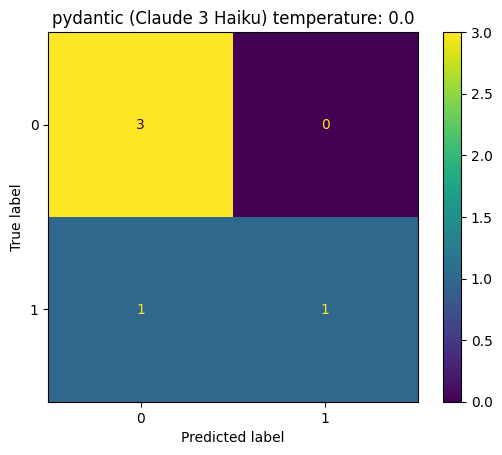

precision: 1.0, recall: 0.5, f1: 0.67



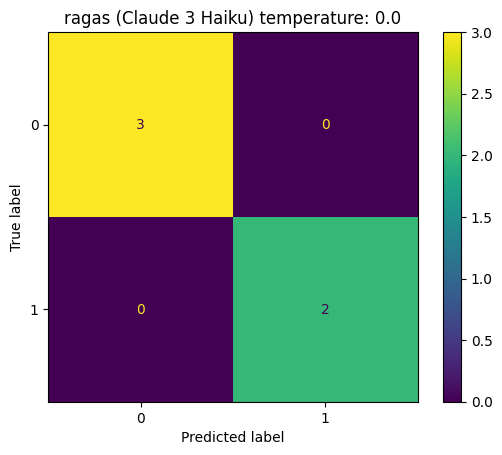

precision: 1.0, recall: 1.0, f1: 1.0



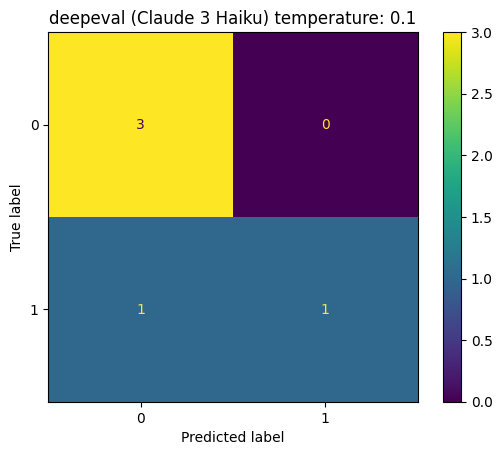

precision: 1.0, recall: 0.5, f1: 0.67



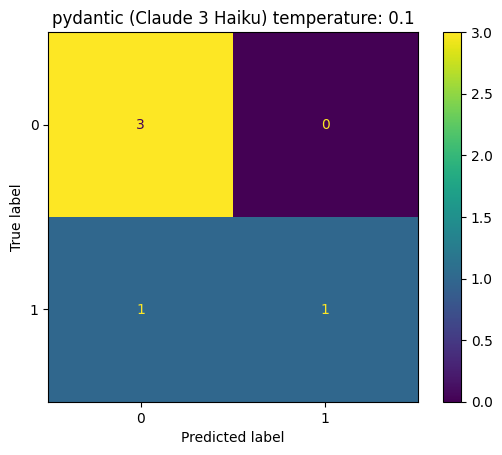

precision: 1.0, recall: 0.5, f1: 0.67



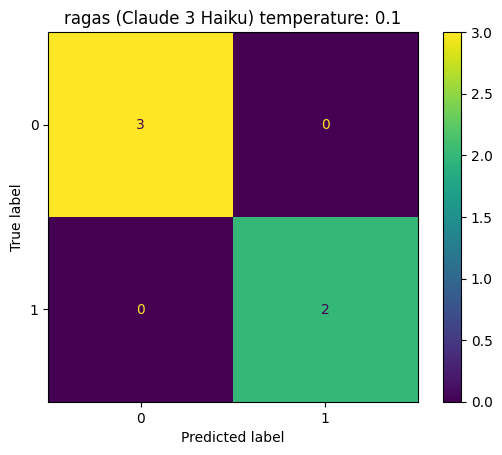

precision: 1.0, recall: 1.0, f1: 1.0



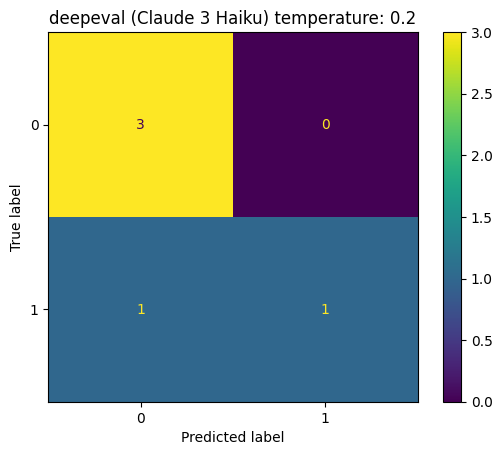

precision: 1.0, recall: 0.5, f1: 0.67



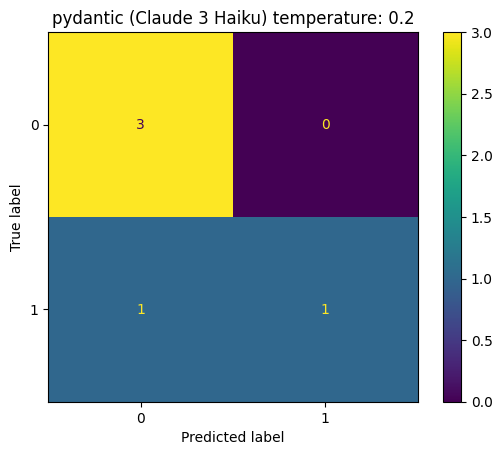

precision: 1.0, recall: 0.5, f1: 0.67



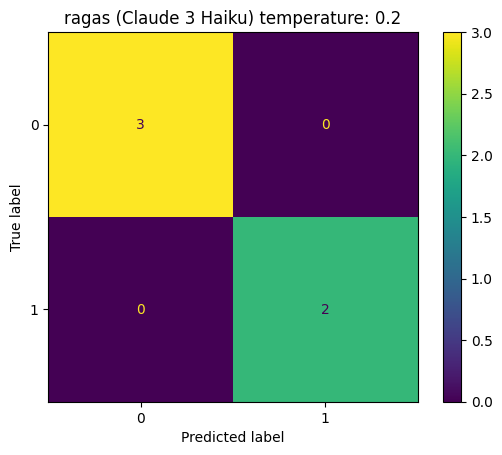

precision: 1.0, recall: 1.0, f1: 1.0



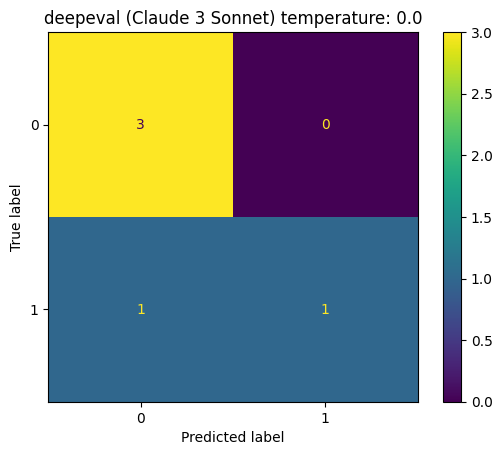

precision: 1.0, recall: 0.5, f1: 0.67



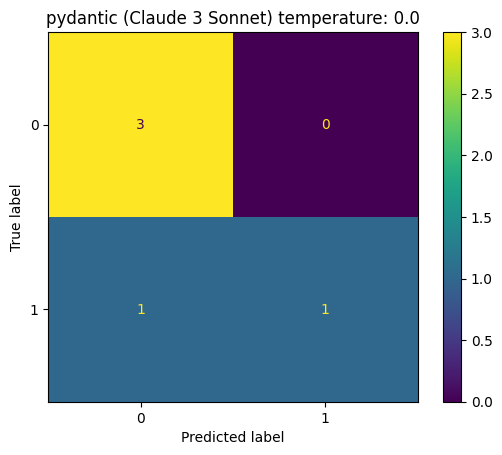

precision: 1.0, recall: 0.5, f1: 0.67



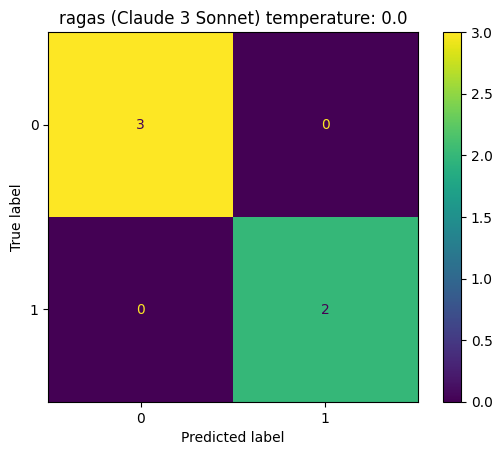

precision: 1.0, recall: 1.0, f1: 1.0



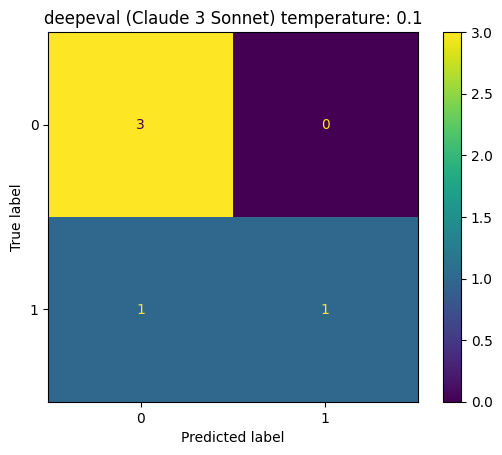

precision: 1.0, recall: 0.5, f1: 0.67



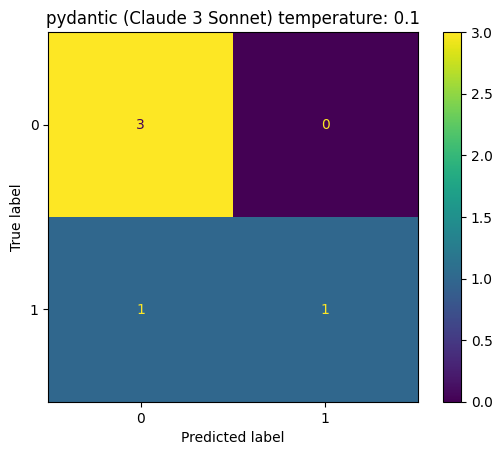

precision: 1.0, recall: 0.5, f1: 0.67



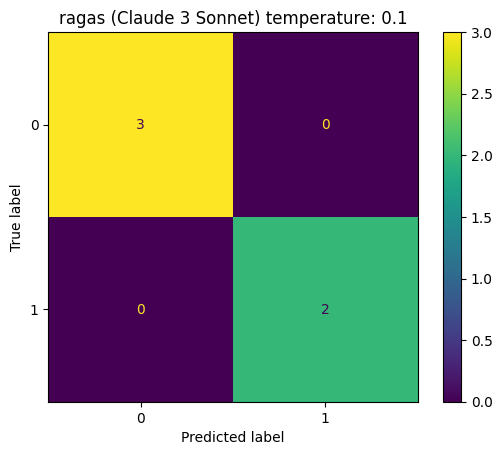

precision: 1.0, recall: 1.0, f1: 1.0



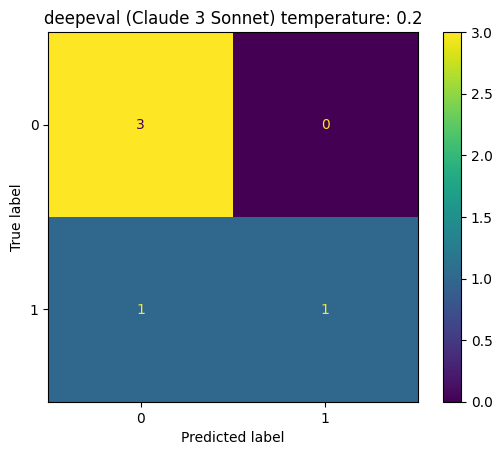

precision: 1.0, recall: 0.5, f1: 0.67



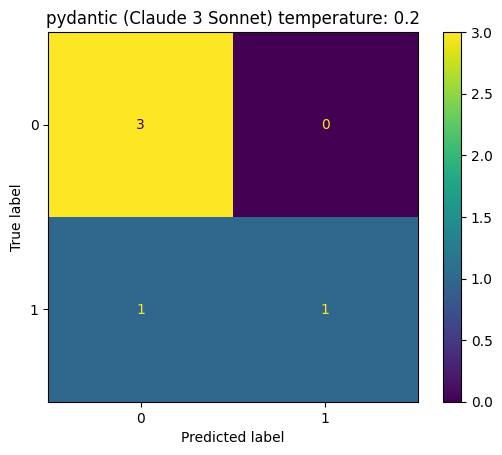

precision: 1.0, recall: 0.5, f1: 0.67



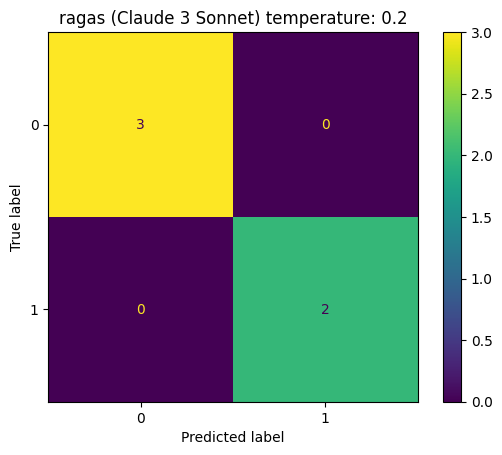

precision: 1.0, recall: 1.0, f1: 1.0



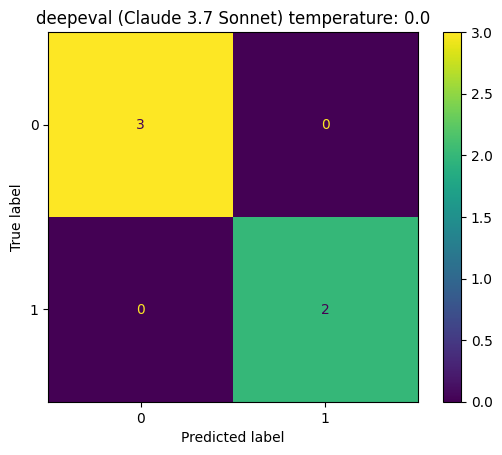

precision: 1.0, recall: 1.0, f1: 1.0



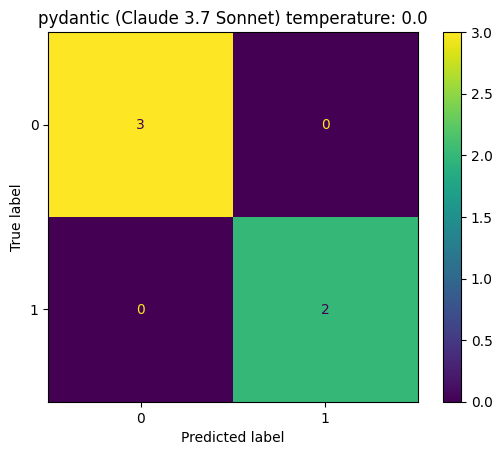

precision: 1.0, recall: 1.0, f1: 1.0



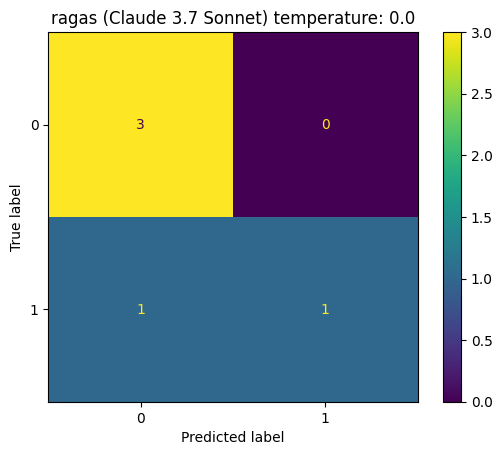

precision: 1.0, recall: 0.5, f1: 0.67



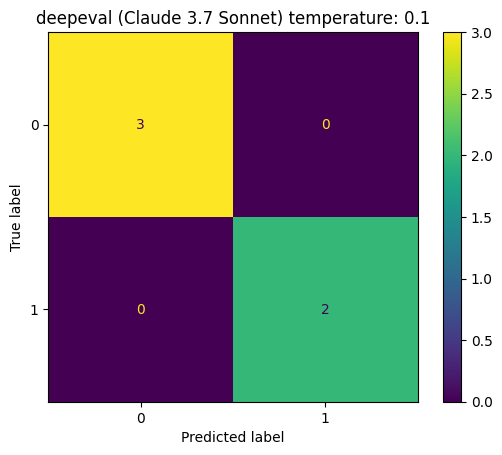

precision: 1.0, recall: 1.0, f1: 1.0



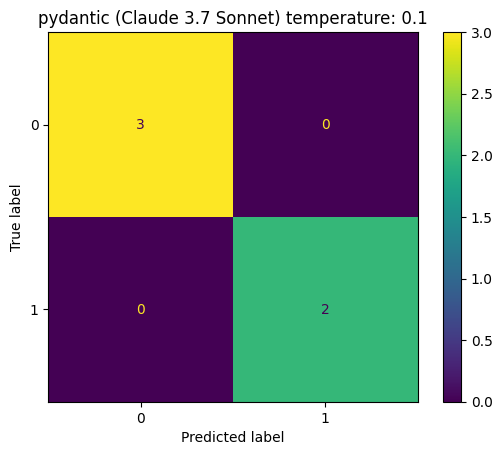

precision: 1.0, recall: 1.0, f1: 1.0



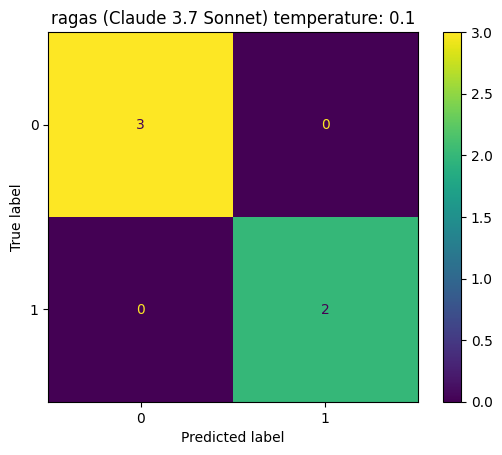

precision: 1.0, recall: 1.0, f1: 1.0



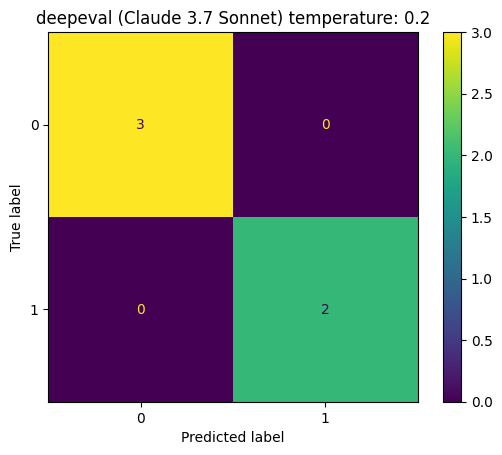

precision: 1.0, recall: 1.0, f1: 1.0



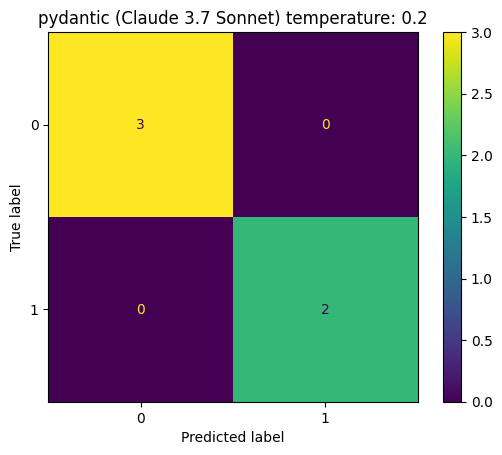

precision: 1.0, recall: 1.0, f1: 1.0



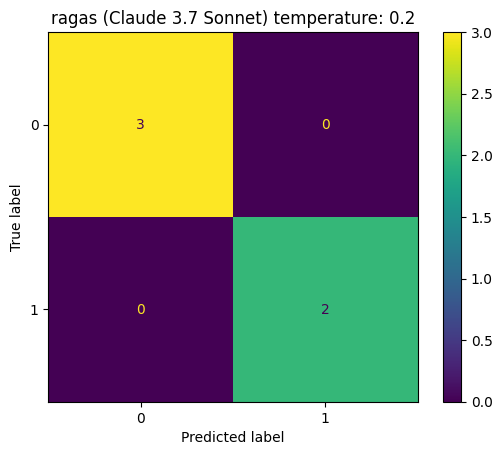

precision: 1.0, recall: 1.0, f1: 1.0



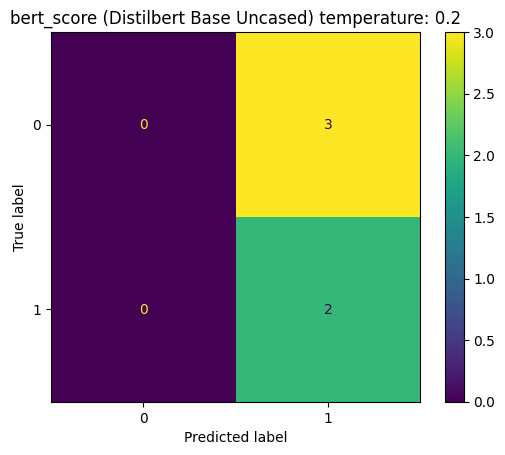

precision: 0.4, recall: 1.0, f1: 0.57



,method,model_name,temperature,score_correct,score_incorrect,score_mean,score_diff,precision,recall,f1
0,deepeval,Claude 3 Haiku,0.0,0.750000,0.233333,0.491667,0.516667,1.0,0.5,0.666667
1,pydantic,Claude 3 Haiku,0.0,0.500000,0.000000,0.250000,0.500000,1.0,0.5,0.666667
2,ragas,Claude 3 Haiku,0.0,0.949372,0.266461,0.607916,0.682911,1.0,1.0,1.000000
3,deepeval,Claude 3 Haiku,0.1,0.750000,0.233333,0.491667,0.516667,1.0,0.5,0.666667
4,pydantic,Claude 3 Haiku,0.1,0.500000,0.166667,0.333333,0.333333,1.0,0.5,0.666667
5,ragas,Claude 3 Haiku,0.1,0.949372,0.266461,0.607916,0.682911,1.0,1.0,1.000000
6,deepeval,Claude 3 Haiku,0.2,0.750000,0.233333,0.491667,0.516667,1.0,0.5,0.666667
7,pydantic,Claude 3 Haiku,0.2,0.500000,0.000000,0.250000,0.500000,1.0,0.5,0.666667
8,ragas,Claude 3 Haiku,0.2,0.949372,0.308127,0.628750,0.641245,1.0,1.0,1.000000
9,deepeval,Claude 3 Sonnet,0.0,0.800000,0.166667,0.483333,0.633333,1.0,0.5,0.666667


In [6]:
filter_columns=["method", "model_name", "model_id", "temperature"]

results_methods = []
for row in evaluation_df[filter_columns].drop_duplicates().to_dict('records'):
    filter_name=f"{row["method"]} ({row["model_name"]})"
    #print(filter_name)
    filter_df = evaluation_df.copy()
    for filter_column in filter_columns:
        filter_df = filter_df[filter_df[filter_column] == row[filter_column]]

    #display(filter_df)
    results = get_results(filter_df)
    #pprint.pprint(results)
    results_methods.append(results)

results_df = pd.DataFrame(results_methods)
results_df.to_csv('output/results.csv', index=False)
results_df     

## Method

,model_name,temperature,score_correct,score_incorrect,score_mean,score_diff,precision,recall,f1
method,,,,,,,,,
deepeval,Claude 3.7 Sonnet,0.0,0.850000,0.000000,0.425000,0.850000,1.0,1.0,1.000000
pydantic,Claude 3.7 Sonnet,0.0,1.000000,0.000000,0.500000,1.000000,1.0,1.0,1.000000
ragas,Claude 3.7 Sonnet,0.0,0.668122,0.141461,0.404791,0.526661,1.0,0.5,0.666667
bert_score,Distilbert Base Uncased,0.2,0.890413,0.797994,0.844204,0.092419,0.4,1.0,0.571429


<Axes: title={'center': 'difference in score vs method'}, xlabel='method', ylabel='score (correct) - score (incorrect)'>

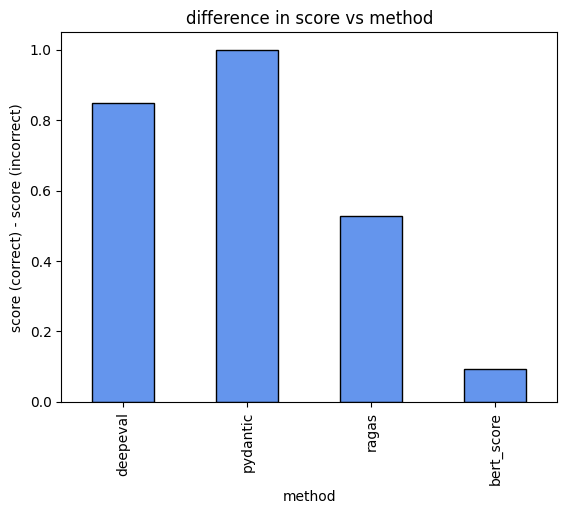

In [64]:
plot_df = results_df[
    ((results_df["temperature"] == "0.0") & (results_df["model_name"] == "Claude 3.7 Sonnet")) |
    (results_df["model_name"] == "Distilbert Base Uncased")
    ].set_index("method")
display(plot_df)

plot_df["score_diff"].plot(kind="bar", ylabel="score (correct) - score (incorrect)", title="difference in score vs method", color="cornflowerblue", edgecolor="black")

<Axes: title={'center': 'f1 vs method'}, xlabel='method', ylabel='f1'>

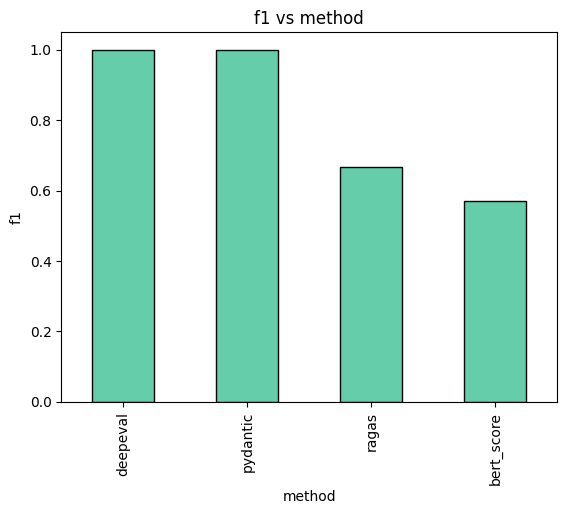

In [65]:
plot_df["f1"].plot(kind="bar", ylabel="f1", title="f1 vs method", color="mediumaquamarine", edgecolor="black")

## Model

,method,temperature,score_correct,score_incorrect,score_mean,score_diff,precision,recall,f1
model_name,,,,,,,,,
Claude 3 Haiku,pydantic,0.0,0.5,0.0,0.25,0.5,1.0,0.5,0.666667
Claude 3 Sonnet,pydantic,0.0,0.5,0.0,0.25,0.5,1.0,0.5,0.666667
Claude 3.7 Sonnet,pydantic,0.0,1.0,0.0,0.50,1.0,1.0,1.0,1.000000


<Axes: title={'center': 'difference in score vs model'}, xlabel='model', ylabel='score (correct) - score (incorrect)'>

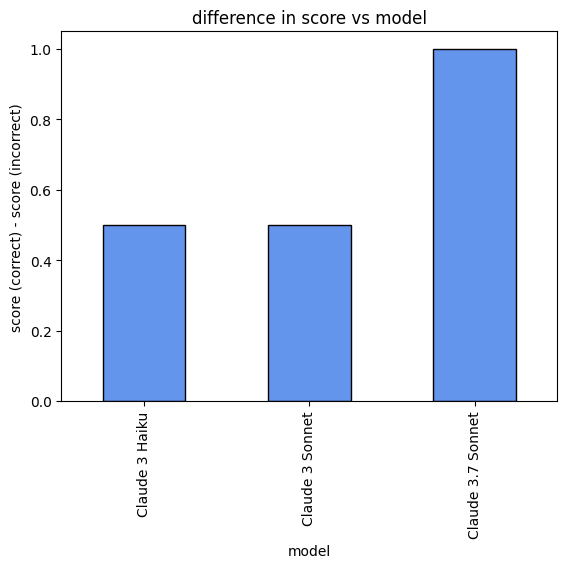

In [66]:
method="pydantic"
temperature="0.0"

plot_df = results_df[
    (results_df["method"] == method) &
    (results_df["temperature"] == temperature)
    ].set_index("model_name")
display(plot_df)

plot_df["score_diff"].plot(kind="bar", xlabel="model",  ylabel="score (correct) - score (incorrect)", title="difference in score vs model", color="cornflowerblue", edgecolor="black")

<Axes: title={'center': 'f1 vs model'}, xlabel='model', ylabel='f1'>

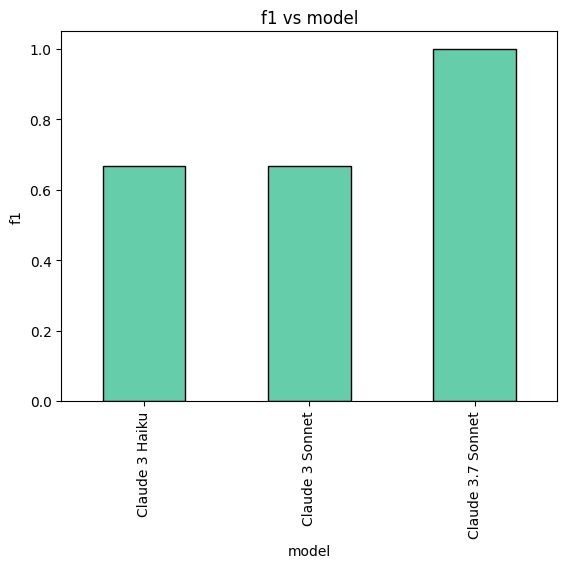

In [67]:
plot_df["f1"].plot(kind="bar", xlabel="model", ylabel="f1", title="f1 vs model", color="mediumaquamarine", edgecolor="black")

## Temperature

,method,model_name,score_correct,score_incorrect,score_mean,score_diff,precision,recall,f1
temperature,,,,,,,,,
0.0,pydantic,Claude 3.7 Sonnet,1.0,0.0,0.5,1.0,1.0,1.0,1.0
0.1,pydantic,Claude 3.7 Sonnet,1.0,0.0,0.5,1.0,1.0,1.0,1.0
0.2,pydantic,Claude 3.7 Sonnet,1.0,0.0,0.5,1.0,1.0,1.0,1.0


<Axes: title={'center': 'difference in score vs temperature'}, xlabel='temperature', ylabel='score (correct) - score (incorrect)'>

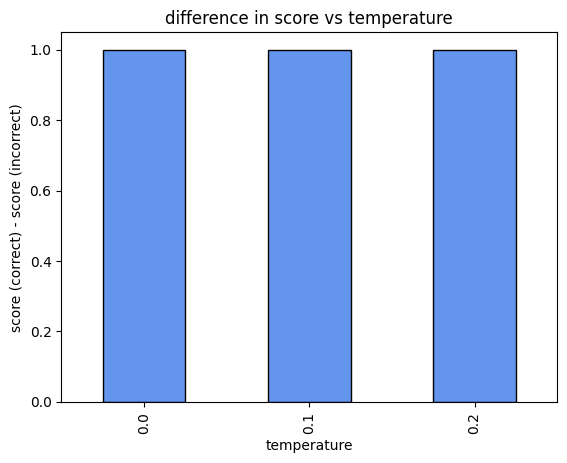

In [68]:
method="pydantic"
model_name="Claude 3.7 Sonnet"

plot_df = results_df[
    (results_df["method"] == method) &
    (results_df["model_name"] == model_name)
    ].set_index("temperature")
display(plot_df)

plot_df["score_diff"].plot(kind="bar", ylabel="score (correct) - score (incorrect)", title="difference in score vs temperature", color="cornflowerblue", edgecolor="black")

<Axes: title={'center': 'f1 vs temperature'}, xlabel='temperature', ylabel='f1'>

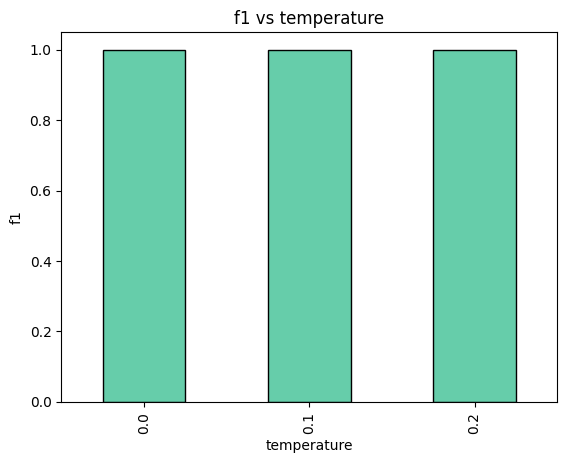

In [69]:
plot_df["f1"].plot(kind="bar", ylabel="f1", title="f1 vs temperature", color="mediumaquamarine", edgecolor="black")